In [1]:
#@title Imports and utility code
!pip install -q uv
!uv pip install -q --system git+https://www.github.com/google/jax-md

import numpy as onp
import jax.numpy as np
import pandas as pd
from jax import random
from jax import jit, grad, jacfwd
from functools import wraps, partial
from jax import lax
from jax import hessian
from jax_md import space, smap, energy, minimize, quantity, simulate, util, partition
from jax_md import elasticity
from jax_md.util import f64 # Call the function
from jax import config
from jax.scipy.special import erfc
config.update('jax_enable_x64', True)
from typing import Tuple, Callable
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from jax_md.colab_tools import renderer
from scipy.optimize import minimize as scipy_min
import html
from IPython.display import HTML, display
Array = util.Array
DisplacementOrMetricFn = space.DisplacementOrMetricFn

def ProgressIter(iter_fun, iter_len=0):
  if not iter_len:
    iter_len = len(iter_fun)
  out = display(progress(0, iter_len), display_id=True)
  for i, it in enumerate(iter_fun):
    yield it
    out.update(progress(i + 1, iter_len))

def progress(value, max):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 45%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

def lattice(R_unit_cell, copies, lattice_vectors):
  """Repeats a unit cell along lattice vectors. """
  lattice_vectors = onp.array(lattice_vectors, f64)

  N, d = R_unit_cell.shape
  if isinstance(copies, int):
    copies = (copies,) * d

  if lattice_vectors.ndim == 0 or lattice_vectors.ndim == 1:
    cartesian = True
    L = onp.eye(d) * lattice_vectors[onp.newaxis, ...]
  elif lattice_vectors.ndim == 2:
    assert lattice_vectors.shape[0] == lattice_vectors.shape[1]
    cartesian = False
    L = onp.eye(d) / onp.array(copies)[onp.newaxis, ...]
    R_unit_cell /= onp.array(copies)[onp.newaxis, ...]
  else:
    raise ValueError()

  Rs = []
  for indices in onp.ndindex(copies):
    dR = 0.
    for idx, i in enumerate(indices):
      dR += i * L[idx]
    R = R_unit_cell + dR[onp.newaxis, :]
    Rs += [R]

  return onp.concatenate(Rs)

def density_sio2(n_atoms,vol):
  n_si = int(n_atoms/3)
  n_o  = int(n_atoms - n_si)
  m_si = 28.0855
  m_o  = 15.9994
  density = ((m_si*n_si) + (m_o*n_o))/(vol*(10**(-24))*(6.02214076*(10**(23))))
  return density

def step_fn(i, state_and_nbrs):
  state, nbrs = state_and_nbrs
  nbrs = neighbor_fn(state.position, nbrs)
  state = apply(state, neighbor=nbrs)
  return state, nbrs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.2/16.2 MB 86.7 MB/s eta 0:00:00


### Define the system

In [2]:
N_muliply = 4

silica_text = """0.000000 0.000000 0.500000 Si
0.000000 0.500000 0.750000 Si
0.500000 0.500000 0.000000 Si
0.500000 0.000000 0.250000 Si
0.087966 0.750000 0.625000 O
0.750000 0.912034 0.375000 O
0.912034 0.250000 0.625000 O
0.250000 0.087966 0.375000 O
0.250000 0.412034 0.875000 O
0.750000 0.587966 0.875000 O
0.587966 0.250000 0.125000 O
0.412034 0.750000 0.125000 O"""

rows = silica_text.split('\n')
rows = np.array([list(map(float,r.split(' ')[:3])) for r in rows])

latvec = np.array([[5.056300, 0.000000, 0.000000],
                    [0.00000, 5.056300, 0.00000],
                    [0.00000, 0.0000, 7.373951]])
R = lattice(rows, N_muliply, latvec)
latvec *= N_muliply
species = np.array([0,0,0,0,1,1,1,1,1,1,1,1]*N_muliply*N_muliply*N_muliply)
R = np.array(R, dtype=f64)
print(R.shape, latvec)

(768, 3) [[20.2252    0.        0.      ]
 [ 0.       20.2252    0.      ]
 [ 0.        0.       29.495804]]


In [3]:
# BKS Potential Parameters.
# Coefficients given in kcal/mol.

CHARGE_OXYGEN = -0.977476019
CHARGE_SILICON = 1.954952037

BKS_SILICA_DICT = {
    'Q_sq' : [[CHARGE_SILICON**2, CHARGE_SILICON*CHARGE_OXYGEN],
              [CHARGE_SILICON*CHARGE_OXYGEN, CHARGE_OXYGEN**2]],
    'exp_coeff' : [[0, 471671.1243 ],
                   [471671.1243, 23138.64826]],
    'exp_decay' : [[1, 0.19173537],
                   [0.19173537, 0.356855265]],
    'attractive_coeff' : [[0, -2156.074422],
                          [-2156.074422, -1879.223108]],
    'repulsive_coeff' : [[78940848.06, 668.7557239],
                         [668.7557239, 2605.841269]],
    'coulomb_alpha' : 0.25,
}

In [4]:
displacement, shift = space.periodic_general(latvec)
dist_fun = space.metric(displacement)
neighbor_fn, energy_fn = energy.bks_silica_neighbor_list(dist_fun,box_size=latvec,species=species, dr_threshold=2.0, **BKS_SILICA_DICT)
nbrs = neighbor_fn.allocate(R, extra_capacity=8)
energy_fn = jit(energy_fn)
kcal_to_eV = 0.04336
eVA3_to_GPa = 160.2176621
pot_e = energy_fn(R, nbrs)
pot_e_eV = kcal_to_eV * pot_e
print(f"{pot_e} kcal/mol {pot_e_eV} eV")

/usr/local/lib/python3.11/dist-packages/jax/_src/ops/scatter.py:92: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


-231841.69128711114 kcal/mol -10052.65573420914 eV


In [5]:
fire_init, fire_apply = minimize.fire_descent(energy_fn, shift, dt_max=0.01, dt_start=0.005)
fire_apply = jit(fire_apply)
fire_state = fire_init(R, neighbor=nbrs)

for k in range(100):
  if k % 5 == 0:
    max_force = np.linalg.norm(fire_state.force)
    pot_e = energy_fn(fire_state.position, nbrs)
    print(f"E = {pot_e * kcal_to_eV} (eV) , Max force = {max_force * kcal_to_eV} eV/A")
  fire_state = fire_apply(fire_state, neighbor=nbrs)
  nbrs = neighbor_fn.update(fire_state.position, nbrs)


R_final = fire_state.position
nbrs_final = neighbor_fn.allocate(R_final)

E = -10052.65573420914 (eV) , Max force = 5.296145968683154 eV/A
E = -10052.851378085383 (eV) , Max force = 5.033551339005807 eV/A
E = -10053.500944119363 (eV) , Max force = 4.059175626751675 eV/A
E = -10054.561712286028 (eV) , Max force = 1.629887795112925 eV/A
E = -10054.777561581843 (eV) , Max force = 0.13390321415624729 eV/A
E = -10054.777790384078 (eV) , Max force = 0.12353016170113838 eV/A
E = -10054.778404942112 (eV) , Max force = 0.08989454800263785 eV/A
E = -10054.779060433615 (eV) , Max force = 0.02025676085569431 eV/A
E = -10054.779085240538 (eV) , Max force = 0.010934902430477416 eV/A
E = -10054.779087194327 (eV) , Max force = 0.009830666331715244 eV/A
E = -10054.779091936904 (eV) , Max force = 0.006402091740557428 eV/A
E = -10054.779095419177 (eV) , Max force = 0.0003577605264050297 eV/A
E = -10054.779095359814 (eV) , Max force = 0.0009079230552012786 eV/A
E = -10054.779095376858 (eV) , Max force = 0.000790177157289582 eV/A
E = -10054.779095413109 (eV) , Max force = 0.0004

In [6]:
print(f"Final energy = {energy_fn(R_final, nbrs_final) * kcal_to_eV} (eV)")
print(f"Final max force = {np.linalg.norm(grad(energy_fn)(R_final, nbrs_final)) * kcal_to_eV} (eV/A)")
print(f"Final pressure = {quantity.stress(energy_fn, position=R_final, box=latvec, neighbor=nbrs_final) * kcal_to_eV * eVA3_to_GPa} (GPa)")

Final energy = -10054.779095430082 (eV)
Final max force = 1.6949668107390407e-06 (eV/A)
Final pressure = [[ 2.62110980e+00  9.88418599e-15 -2.00721389e-16]
 [ 1.00805605e-14  2.62110980e+00  9.68372030e-15]
 [ 3.27930167e-16  9.34211039e-15  3.09169791e+00]] (GPa)


In [7]:
emt_fn = jit(elasticity.athermal_moduli(energy_fn, check_convergence=True))
C_org, converged = emt_fn(R_final,latvec,neighbor=nbrs_final)

In [8]:
def voigt_to_mandel(C_voigt):
    """
    Convert 6x6 elastic tensor from Voigt to Mandel notation

    Args:
        C_voigt: 6x6 numpy array in Voigt notation
    Returns:
        C_mandel: 6x6 numpy array in Mandel notation
    """
    C_mandel = C_voigt.copy()

    # Scale shear components
    # Multiply rows 4-6 by √2
    C_mandel = C_mandel.at[3:, :].set(C_mandel[3:, :]*2**0.5)
    # Multiply columns 4-6 by √2
    C_mandel = C_mandel.at[:, 3:].set(C_mandel[:, 3:]*2**0.5)

    return C_mandel

C_exp_ref = np.array([[86.8, 7.0, 19.1,0,0,0],
                    [7.0, 86.8, 19.1,0,0,0],
                    [19.1, 19.1, 105.8,0,0,0],
                    [0,0,0,58.2,0,0],
                    [0,0,0,0,58.2,0],
                    [0,0,0,0,0,39.9]],dtype=f64)

C_exp = voigt_to_mandel(C_exp_ref)
C_c_org = elasticity.tensor_to_mandel(C_org) * kcal_to_eV * eVA3_to_GPa
print(converged)
print(f"Experimental =\n{round(C_exp, 4)}")
print(f"Original =\n{round(C_c_org, 4)}")

True
Experimental =
[[ 86.8   7.   19.1   0.    0.    0. ]
 [  7.   86.8  19.1   0.    0.    0. ]
 [ 19.1  19.1 105.8   0.    0.    0. ]
 [  0.    0.    0.  116.4   0.    0. ]
 [  0.    0.    0.    0.  116.4   0. ]
 [  0.    0.    0.    0.    0.   79.8]]
Original =
[[ 63.3545 -39.0365  12.4639   0.      -0.       0.    ]
 [-39.0365  63.3545  12.4639  -0.       0.       0.    ]
 [ 12.4639  12.4639  80.8784   0.       0.       0.    ]
 [  0.      -0.       0.      21.764   -0.      -0.    ]
 [ -0.       0.       0.      -0.      21.764   -0.    ]
 [  0.       0.       0.      -0.      -0.      46.4475]]


In [9]:
print('Bulk modulus with E_nl (athermal) = {} GPa'.format(elasticity.extract_isotropic_moduli(C_org)['B'] * kcal_to_eV * eVA3_to_GPa))
print('Shear modulus with E_nl (athermal) = {} GPa'.format(elasticity.extract_isotropic_moduli(C_org)['G'] * kcal_to_eV * eVA3_to_GPa))

Bulk modulus with E_nl (athermal) = 19.930007476600707 GPa
Shear modulus with E_nl (athermal) = 23.77728914750916 GPa


## Objective function and optimization

In [10]:
def setup(R, latvec, nbrs, C_target):
  displacement, shift = space.periodic_general(latvec)
  dist_fun = space.metric(displacement)
  def run(params: np.array):
    BKS_SILICA_DICT['exp_coeff'] = np.array([[0.0, params[0]],[params[0], params[1]]],dtype=f64)
    BKS_SILICA_DICT['attractive_coeff'] = np.array([[0.0, params[2]],[params[2], params[3]]],dtype=f64)
    neighbor_fn, energy_fn = energy.bks_silica_neighbor_list(dist_fun, box_size=latvec, species=species, dr_threshold=2.0, **BKS_SILICA_DICT)
    emt_fn = elasticity.athermal_moduli(energy_fn, check_convergence=True)
    C, converged = emt_fn(R, latvec, neighbor=nbrs)
    C_c = elasticity.tensor_to_mandel(C) * kcal_to_eV * eVA3_to_GPa
    return np.linalg.norm(C_c - C_target,ord='fro') # The Quantity to minimize
  return run

nbrs = neighbor_fn.allocate(R_final)
run = setup(R_final, latvec, nbrs, C_target=C_exp)

In [11]:
# jit the function
run_jit = jit(run)
grad_params = jit(jacfwd(run, has_aux=False))

In [12]:
A_ij = np.array([[0, 471671.1243],[471671.1243, 23138.64826]], dtype=f64)
C_ij = np.array([[0, -2156.074422],[-2156.074422, -1879.223108]], dtype=f64)
params = np.array([A_ij[1,0], A_ij[1,1],
                   C_ij[1,0], C_ij[1,1]],dtype=f64)
print(f"Initial params = {params}")

Initial params = [471671.1243    23138.64826   -2156.074422  -1879.223108]


In [13]:
print(f"Function value = {run_jit(params)}")
print(f"Gradients = {grad_params(params)}")

Function value = 158.61807599664283
Gradients = [0.00941203 0.0283369  1.7013343  0.09710623]


In [14]:
# Uncomment to run (might take time)
'''# Print callback function
def print3x(params):
    global Nfeval
    global fout
    fout.write('{0:4d},{1:3.12f},{2: 3.12f},{3:3.12f},{4: 3.12f},{5:3.12f},{6: 3.12f}'.format(Nfeval,
                                                                          params[0], params[1], params[2],
                                                                          params[3],
                                                                          run(params), np.amax(np.abs(grad_params(params)))) + '\n')
    Nfeval += 1

Nfeval = 1
fout = open('CG_logs.dat','w')
fout.write('iter,A_Si_O,A_O_O,C_Si_O,C_O_O,obj_fun,grad_max \n')
res = scipy_min(run, params, jac=grad_params, method='CG', callback=print3x, options={'disp': True,
                                                                                      'maxiter': 30,
                                                                                      'gtol' : 1e-30}, tol=1e-30)
fout.close()
res'''

"# Print callback function\ndef print3x(params):\n    global Nfeval\n    global fout\n    fout.write('{0:4d},{1:3.12f},{2: 3.12f},{3:3.12f},{4: 3.12f},{5:3.12f},{6: 3.12f}'.format(Nfeval,\n                                                                          params[0], params[1], params[2],\n                                                                          params[3],\n                                                                          run(params), np.amax(np.abs(grad_params(params)))) + '\n')\n    Nfeval += 1\n\nNfeval = 1\nfout = open('CG_logs.dat','w')\nfout.write('iter,A_Si_O,A_O_O,C_Si_O,C_O_O,obj_fun,grad_max \n')\nres = scipy_min(run, params, jac=grad_params, method='CG', callback=print3x, options={'disp': True,\n                                                                                      'maxiter': 30,\n                                                                                      'gtol' : 1e-30}, tol=1e-30)\nfout.close()\nres"

## Final results

In [15]:
!wget -q https://raw.githubusercontent.com/M3RG-IITD/Force-field-optimization/refs/heads/main/SiO2_FF/CG_logs.dat
cg_og1_1 = pd.read_csv("/content/CG_logs.dat",delimiter=",")

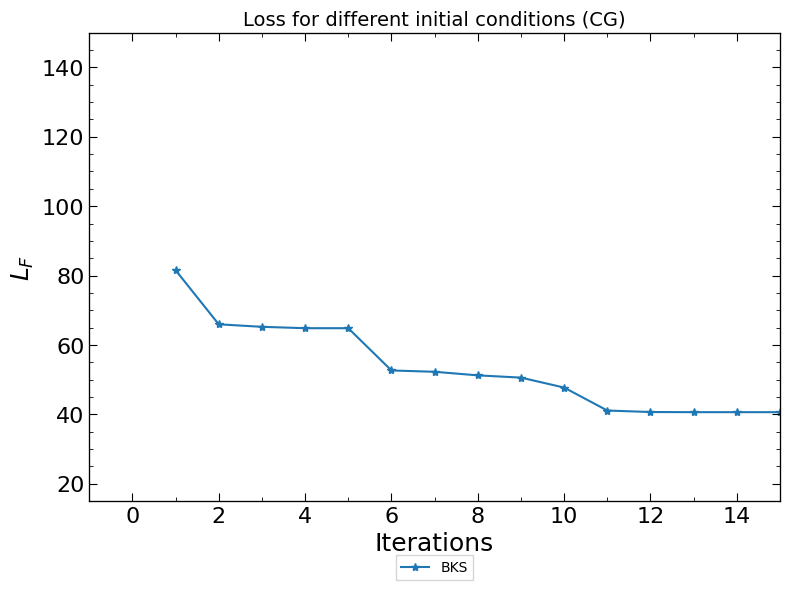

In [16]:
fig, ax1 = plt.subplots(1, 1, figsize=(8, 6),
                        gridspec_kw={'width_ratios': [1]})

ax2 = ax1.twinx()
ax3 = ax1.twiny()
plt.title("Loss for different initial conditions (CG)",fontsize=14)

ax1.plot(cg_og1_1['iter'],cg_og1_1['obj_fun'],"-*",label="BKS")

ax1.xaxis.set_minor_locator(MultipleLocator(1))
ax1.yaxis.set_minor_locator(MultipleLocator(5))
ax1.tick_params(axis="y", direction='in', length=6, labelsize=16)
ax1.tick_params(axis="x", direction='in', length=6, labelsize=16)
ax1.tick_params(which='minor', length=3, direction='in')

ax1.set_xlabel("Iterations",fontsize=18)
ax1.set_ylabel("$L_{F}$",fontsize=18)
ax1.set_xlim(-1,15)
ax1.set_ylim(15,150)

ax2.set_ylim(15,150)
ax2.yaxis.set_minor_locator(MultipleLocator(5))
ax2.tick_params(axis="y", direction='in', length=6)
ax2.tick_params(which='minor', length=3, direction='in')
ax2.set_yticklabels([])

ax3.set_xlim(-1,15)
ax3.xaxis.set_minor_locator(MultipleLocator(1))
ax3.tick_params(axis="x", direction='in', length=6)
ax3.tick_params(which='minor', length=3, direction='in')
ax3.set_xticklabels([])
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=False, shadow=False, ncol=5)

plt.savefig("loss_CG.pdf",dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

In [17]:

A_Si_O = cg_og1_1['A_Si_O'].values[-1]
A_O_O = cg_og1_1['A_O_O'].values[-1]

C_Si_O = cg_og1_1['C_Si_O'].values[-1]
C_O_O = cg_og1_1['C_O_O'].values[-1]

BKS_SILICA_DICT['exp_coeff'] = np.array([[0.0, A_Si_O],[A_Si_O, A_O_O]],dtype=f64)
BKS_SILICA_DICT['attractive_coeff'] = np.array([[0.0, C_Si_O],[C_Si_O, C_O_O]],dtype=f64)
neighbor_fn, energy_fn = energy.bks_silica_neighbor_list(dist_fun,
                                                         box_size=latvec,
                                                         species=species, dr_threshold=2.0, **BKS_SILICA_DICT)
emt_fn = elasticity.athermal_moduli(energy_fn, check_convergence=True)
C_opt, converged = emt_fn(R_final, latvec, neighbor=nbrs_final)
C_c_opt = elasticity.tensor_to_mandel(C_opt) * kcal_to_eV * eVA3_to_GPa
print(converged)
print(f"Original =\n{round(C_c_org, 4)}")
print(f"Experimental =\n{round(C_exp, 4)}")
print(f"Optimized =\n{round(C_c_opt, 4)}")

True
Original =
[[ 63.3545 -39.0365  12.4639   0.      -0.       0.    ]
 [-39.0365  63.3545  12.4639  -0.       0.       0.    ]
 [ 12.4639  12.4639  80.8784   0.       0.       0.    ]
 [  0.      -0.       0.      21.764   -0.      -0.    ]
 [ -0.       0.       0.      -0.      21.764   -0.    ]
 [  0.       0.       0.      -0.      -0.      46.4475]]
Experimental =
[[ 86.8   7.   19.1   0.    0.    0. ]
 [  7.   86.8  19.1   0.    0.    0. ]
 [ 19.1  19.1 105.8   0.    0.    0. ]
 [  0.    0.    0.  116.4   0.    0. ]
 [  0.    0.    0.    0.  116.4   0. ]
 [  0.    0.    0.    0.    0.   79.8]]
Optimized =
[[ 86.4761  -9.9265  24.2253   0.      -0.       0.    ]
 [ -9.9265  86.4761  24.2253  -0.       0.       0.    ]
 [ 24.2253  24.2253 122.1463  -0.       0.      -0.    ]
 [  0.      -0.      -0.     103.5855   0.       0.    ]
 [ -0.       0.       0.       0.     103.5855   0.    ]
 [  0.       0.      -0.       0.       0.      69.8249]]


In [18]:
print('Bulk modulus with E_nl (athermal) = {} GPa'.format(elasticity.extract_isotropic_moduli(C_opt)['B'] * kcal_to_eV * eVA3_to_GPa))
print('Shear modulus with E_nl (athermal) = {} GPa'.format(elasticity.extract_isotropic_moduli(C_opt)['G'] * kcal_to_eV * eVA3_to_GPa))

Bulk modulus with E_nl (athermal) = 41.34961524145465 GPa
Shear modulus with E_nl (athermal) = 44.80455107031862 GPa


In [19]:
print(f"Final A_ij = \n{BKS_SILICA_DICT['exp_coeff']}")
print(f"Final C_ij = \n{BKS_SILICA_DICT['attractive_coeff']}")

Final A_ij = 
[[     0.         470198.42575813]
 [470198.42575813  42338.96950494]]
Final C_ij = 
[[    0.        -2757.3276161]
 [-2757.3276161 -6797.3189433]]
